In [10]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [11]:
#Read tweets from csv file
df=pd.read_csv("../Raw Data/Trump tweets 3 day groups jan-dec 2017.csv")

#Changing the date format
for index, row in df.iterrows():
    #row['startdate']=row['startdate'].date()
    d= datetime.strptime(row['created_at'], '%m/%d/%Y')
    df.loc[index, 'created_at'] = d.strftime('%Y-%m-%d')
df.head()

,text,created_at,Unique Identifier
0,It all begins today! I will see you at 11:00 A...,2017-01-20,1
1,Today we are not merely transferring power fro...,2017-01-20,1
2,power from Washington D.C. and giving it back ...,2017-01-20,1
3,What truly matters is not which party controls...,2017-01-20,1
4,January 20th 2017 will be remembered as the da...,2017-01-20,1


In [12]:
#first tweet variable
#true for the first time then set to false
firstTweet = True

#list to store compound sentiment for each tweet
#once unique identifier is different averaged and emptied
compound_list =[]

#Array to store average compound sentiments
sentiments =[]
count =0

#Iterate over all the tweet data stored in dataframe
for index, row in df.iterrows():
    
    #Run Vader Analysis on each tweet
    sentence =row["text"]
    
    #Getting average compund sentiment for three days
    #Three days tweets have same unique identifier
    new_id =row["Unique Identifier"]
    
    #If not first tweet 
        ##Check if the old and new unique identifiers are different
            ####If different save the average compound sentiment
            ####Empty the compound list
            ####Add the average compound sentiment to an array
            ####Set the counter to 0
            ####Set the old_date  value
    #Else 
    ##Set firstTweet to false
    ##Set the ol_date for first set of sentiments 
    if(firstTweet == False):               
        if(old_id != new_id):
            compound= np.mean(compound_list)
            compound_list =[]
            sentiments.append({"Compound":compound,
                "Date" : old_date,
                "Count" : count})
            count =0
            old_date = row["created_at"]
    else:
        firstTweet = False
        old_date = row["created_at"]
    
    #Add all the tweet to compound list
    #Increment the counter
    #Change the old_id and old_values     
    compound_list.append(analyzer.polarity_scores(sentence)["compound"])
    count +=1
    old_id = new_id
        
#Add the final set of average compund sentiment
sentiments.append({"Compound":compound,
                "Date" : old_date,
                "Count" : count})

In [13]:
#Put all data into dataframe sentiments_df
sentiments_df = pd.DataFrame.from_dict(sentiments)
sentiments_df =sentiments_df[['Date','Compound','Count']]
sentiments_df.head()

,Date,Compound,Count
0,2017-01-20,0.185511,18
1,2017-01-23,0.183223,13
2,2017-01-26,0.106478,23
3,2017-01-29,-0.232106,17
4,2017-02-01,0.069474,19


In [14]:
#Read tweets approval ratings from csv file
df1=pd.read_csv("../Raw Data/approval data clean values only.csv")
df1.head()

,Start Date,End Date,Average of adjusted_approve,Average of adjusted_disapprove
0,1/20/2017,1/22/2017,45.90613,43.14093
1,1/23/2017,1/25/2017,43.71903,40.23624
2,1/26/2017,1/28/2017,42.90613,49.14093
3,1/29/2017,1/31/2017,43.90613,50.14093
4,2/1/2017,2/3/2017,44.90613,48.14093


In [15]:
#Changing the date format
#Keeping only one date and renaming it to 'Date'
#Filtering the data to keep values only from 2017-01-20 to 2017-12-31
for index, row in df1.iterrows():
    d= datetime.strptime(row['Start Date'], '%m/%d/%Y')
    df1.loc[index, 'Start Date'] = d.strftime('%Y-%m-%d')
df1.rename( columns={"Start Date": "Date"}, inplace=True)
df1=df1.loc[(df1['Date'] > '2017-01-19') & (df1['Date'] < '2018-01-01')]
approval_df=df1[['Date','Average of adjusted_approve','Average of adjusted_disapprove']]

#Performing merge based on the 'Date' column
#Removing any rows having NaN values or no values
correlate_df =sentiments_df.merge(approval_df,on='Date',how="outer")
correlate_df =correlate_df[['Date','Compound','Average of adjusted_approve','Average of adjusted_disapprove']]
correlate_df.rename( columns={"Average of adjusted_approve": "Approve","Average of adjusted_disapprove": "Disapprove"}, inplace=True)
correlate_df = correlate_df.dropna(axis=0, how='any')
correlate_df.head()

,Date,Compound,Approve,Disapprove
0,2017-01-20,0.185511,45.90613,43.14093
1,2017-01-23,0.183223,43.71903,40.23624
2,2017-01-26,0.106478,42.90613,49.14093
3,2017-01-29,-0.232106,43.90613,50.14093
4,2017-02-01,0.069474,44.90613,48.14093


In [16]:
correlate_df.dtypes

Date           object
Compound      float64
Approve       float64
Disapprove    float64
dtype: object

In [17]:
correlate_df.shape

(109, 4)

In [18]:
#Remove rows with duplicate column values for aproval and sentiment
alphas_df=correlate_df.drop_duplicates(subset='Approve', keep="first")
deltas_df=alphas_df.drop_duplicates(subset='Compound', keep="first")

In [19]:
#put approval and sentiment dataa in array
approval_values = deltas_df['Approve'].unique()
compound_values = deltas_df['Compound'].unique()

In [20]:
delta_approval = []
delta_compound = []


In [21]:
for i in range(29):
    delta_approval.append(float(approval_values[i + 1]) - float(approval_values[i]))
    delta_compound.append(float(compound_values[i + 1]) - float(compound_values[i]))

In [22]:
delta_approval = delta_approval[:29]
delta_compound = delta_compound[:29]

In [23]:
days = np.arange(29)

In [24]:
deltas_df = pd.DataFrame({'Day Number': days, 'Delta Approval': delta_approval, 'Delta Compound': delta_compound})

In [25]:
deltas_df.head()

,Day Number,Delta Approval,Delta Compound
0,0,-2.1871,-0.002288
1,1,-0.8129,-0.076745
2,2,1.0000,-0.338584
3,3,1.0000,0.301580
4,4,-4.0000,0.012550


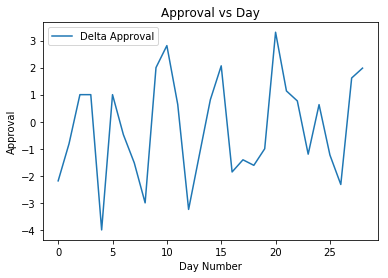

In [42]:
deltas_df.plot.line(x = 'Day Number', y = 'Delta Approval')
plt.xlabel("Day Number")
plt.ylabel('Approval')
plt.title('Approval vs Day')
plt.show()

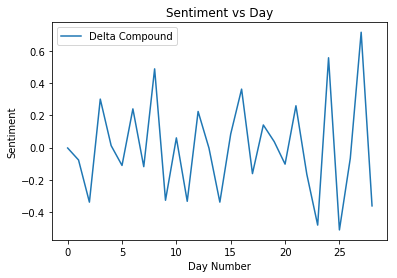

In [43]:
deltas_df.plot.line(x = 'Day Number', y = 'Delta Compound')
plt.xlabel("Day Number")
plt.ylabel('Sentiment')
plt.title('Sentiment vs Day')
plt.show()

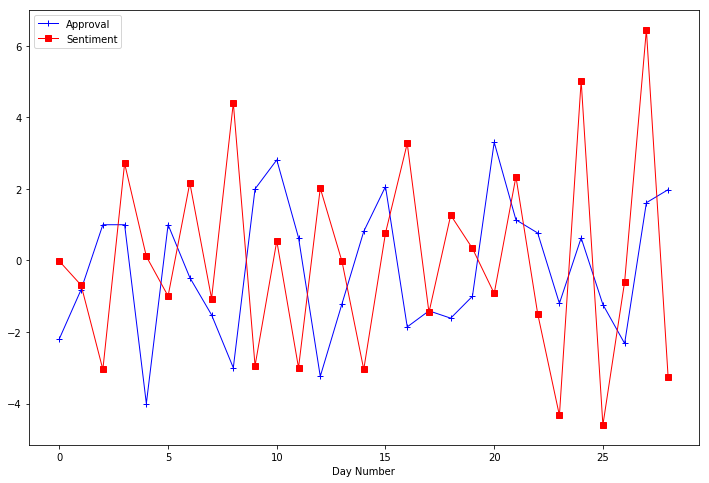

In [38]:
plt.figure(figsize=(12,8))
x_axis = deltas_df['Day Number']
# Create a handle for each plot
Approve = plt.plot(x_axis, deltas_df['Delta Approval'], marker="+",color="blue", linewidth=1, label="Approval")
Compound= plt.plot(x_axis, deltas_df['Delta Compound']*9, marker="s", color="Red", linewidth=1, label="Sentiment")
plt.xlabel("Day Number")
plt.ylabel('')
plt.title('')
plt.legend()
plt.show()

In [30]:
deltas_df.describe()

,Day Number,Delta Approval,Delta Compound
count,29.000000,29.000000,29.000000
mean,14.000000,-0.217649,-0.000185
std,8.514693,1.898771,0.308739
min,0.000000,-4.000000,-0.511207
25%,7.000000,-1.520933,-0.165286
50%,14.000000,-0.479067,-0.003070
75%,21.000000,1.000000,0.224747
max,28.000000,3.306890,0.717031


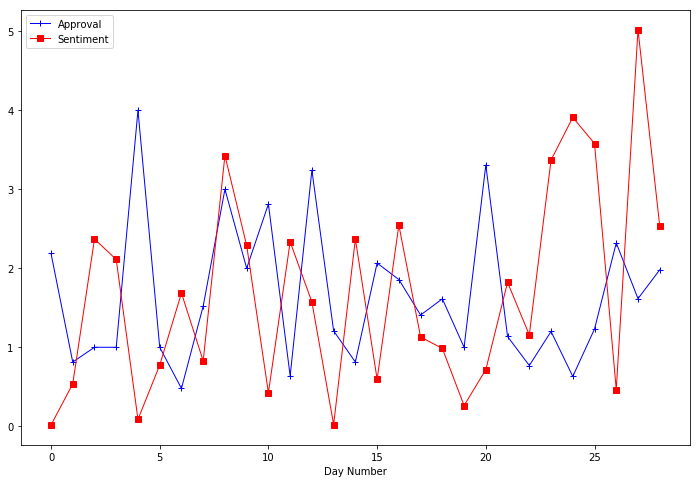

In [40]:
plt.figure(figsize=(12,8))
x_axis = deltas_df['Day Number']
# Create a handle for each plot
Approve = plt.plot(x_axis, np.sqrt(np.square(deltas_df['Delta Approval'])), marker="+",color="blue", linewidth=1, label="Approval")
Compound = plt.plot(x_axis, np.sqrt(np.square(deltas_df['Delta Compound']*7)), marker="s", color="Red", linewidth=1, label="Sentiment")
plt.xlabel("Day Number")
plt.ylabel('')
plt.title('')
plt.legend()
plt.show()

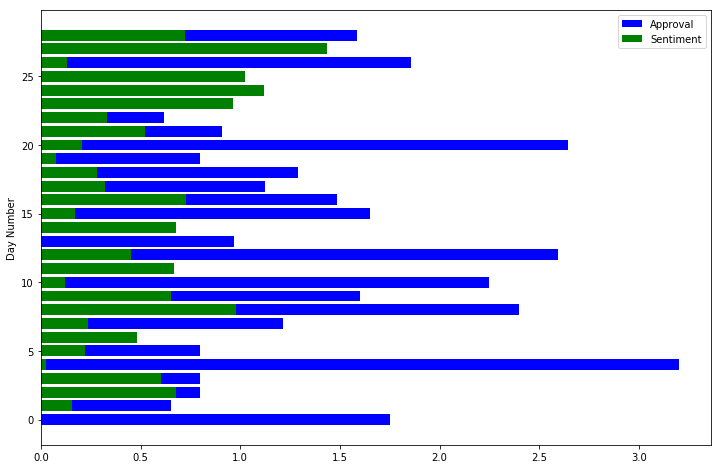

In [41]:
#Create a barplot for sentiment analysis and approval
plt.figure(figsize=(12,8))
plt.barh(x_axis, np.sqrt(np.square(deltas_df['Delta Approval']*.8)), color="blue",label="Approval")
plt.barh(x_axis, np.sqrt(np.square(deltas_df['Delta Compound']*2)), color="green",label="Sentiment")
plt.ylabel("Day Number")
plt.title('')
plt.legend()
plt.show()